In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from multiprocessing import Pool
from scipy.constants import c
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import norm
plt.style.use("huntstone")
import numpy as np
import sys
sys.path.insert(0, "../../python")
import currents as cp
from plotting import makefig
import eo_signal as eos

In [2]:
def I_stats(ind):
    I, ti, p2p = cp.get_current(ind)
    # Get drive and witness currents
    dI = I[np.argmin(abs(ti))]
    dw = I[np.argmin(abs(ti - p2p))]
    ind1 = np.argmin(abs(ti))
    ind2 = np.argmin(abs(ti - 0.02e-12))
    sep = ind2 - ind1
    #npeaks = 10
    cut    = 0.1
    #while npeaks > 4:
    peaks = find_peaks(I, height = cut*dI, distance = 18, prominence = 10)[0]
    npeaks = len(peaks)
    return p2p*c*1e6, dI, dw, npeaks
def peak_study(ind):
    I, ti, p2p, sig, t_sig, g, tg = eos.get_signal(ind, "GaP", 100e-6, 800e-9, 30e-15, 15, 1e-3, "cross")
    return max(I), max(sig)

def plot_param(data, name):
    
    fig, ax = makefig()
    n, bins, patches = ax.hist(data, facecolor='blue', alpha=0.75)
    mu = np.mean(data)
    sigma = np.std(data)
    tstring = name + "\n" + r'($\mu$, $\sigma$) = ('\
             + np.str(np.round(mu,2)) + ", " + np.str(np.round(sigma,2)) +')'
    ax.set_title(tstring)
    text = r'$\mu$ = ' + str(np.round(mu,2)) + \
          "\n" + r'$\sigma$ = ' + str(np.round(sigma,2))
    plt.show()

In [3]:
inds = np.arange(0, 3134, 1)
p    = Pool(4)
I_max, S_max = zip(*p.map(peak_study, inds))
p.close()
p.join()

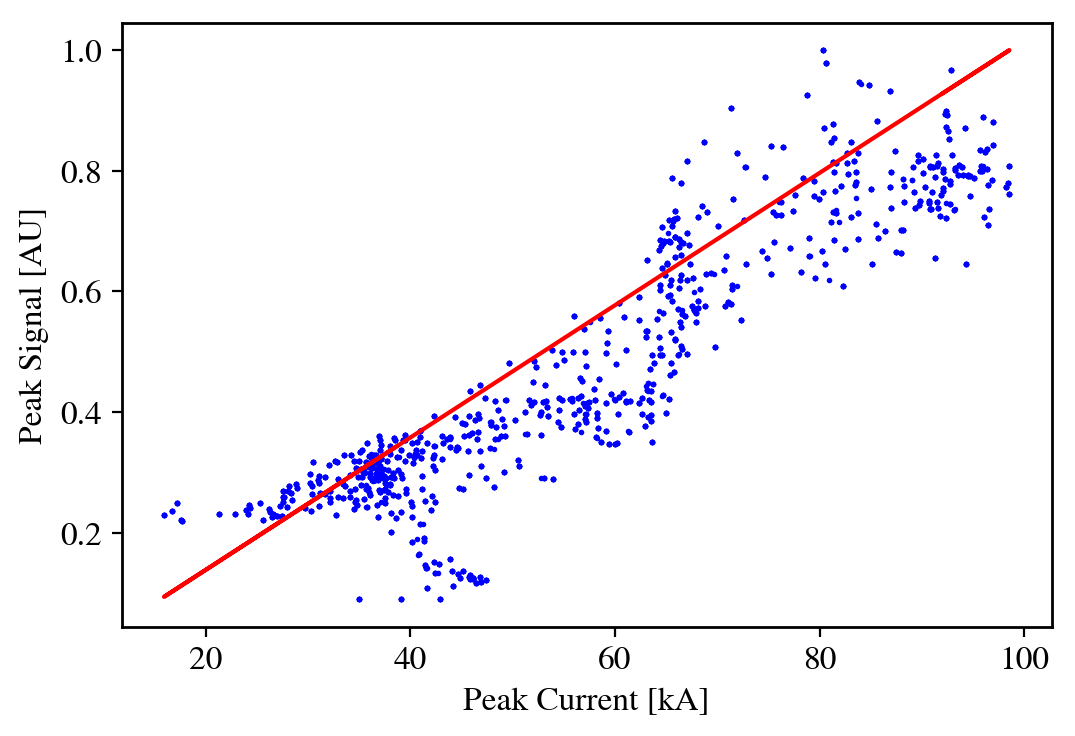

In [55]:
fig, ax = makefig()
ind = np.argsort(I_max)
ax.plot(I_max, S_max / max(S_max), 'bo', markersize=1)
coef1     = np.polyfit(I_max,S_max,1)
poly1d_fn = np.poly1d(coef1)
f1_line   = poly1d_fn(I_max)
f1_line   = f1_line / max(f1_line)

def fit_func(x, a, b, c, p):
    return a*x + b * np.sin(x + p) + c

popt, pcov = curve_fit(fit_func, I_max, S_max, p0=(1e-3, 1, 1, 1))
f2_line    = fit_func(np.array(I_max), *popt)
ax.plot(I_max, f1_line, '-r')
ax.set_ylabel("Peak Signal [AU]")
ax.set_xlabel("Peak Current [kA]")
plt.show()

In [50]:
popt

array([-3.85181392e+01, -4.39965776e-06,  3.85168839e+01])

In [3]:
inds  = np.arange(0, 3134, 1)
p = Pool(4)
p2ps, dI, dw, npeaks = zip(*p.map(I_stats, inds))
p.close()
p.join()

In [5]:
np.mean(p2ps)

150.426314715368

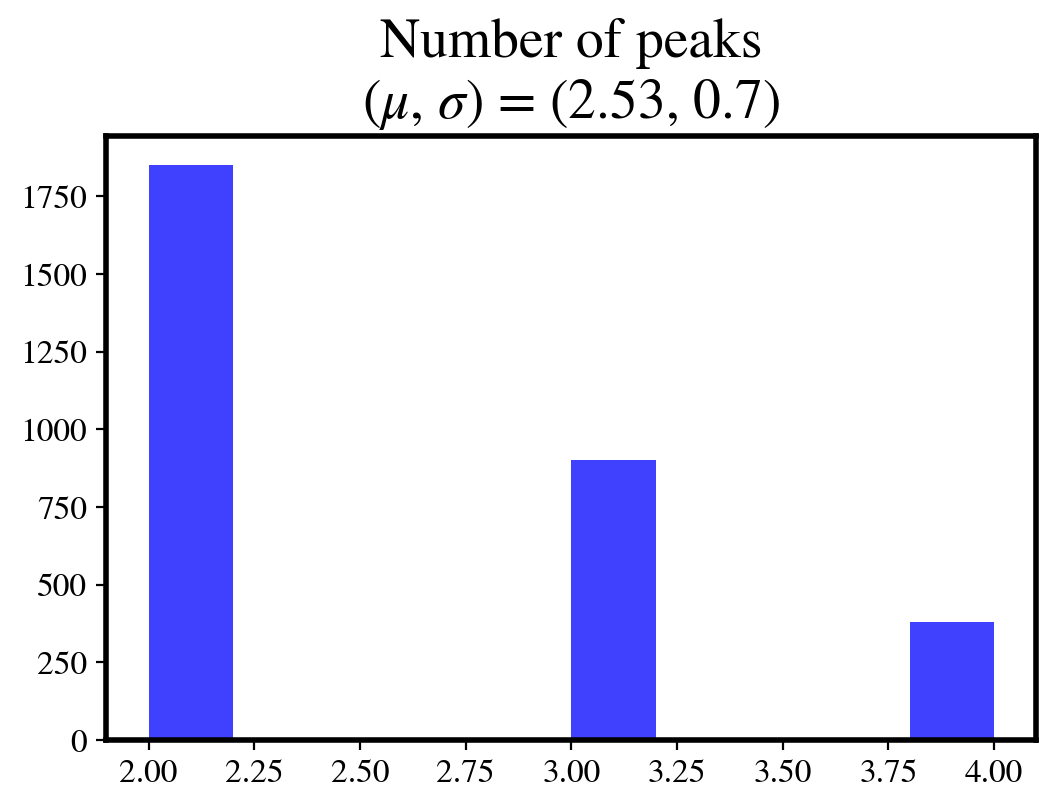

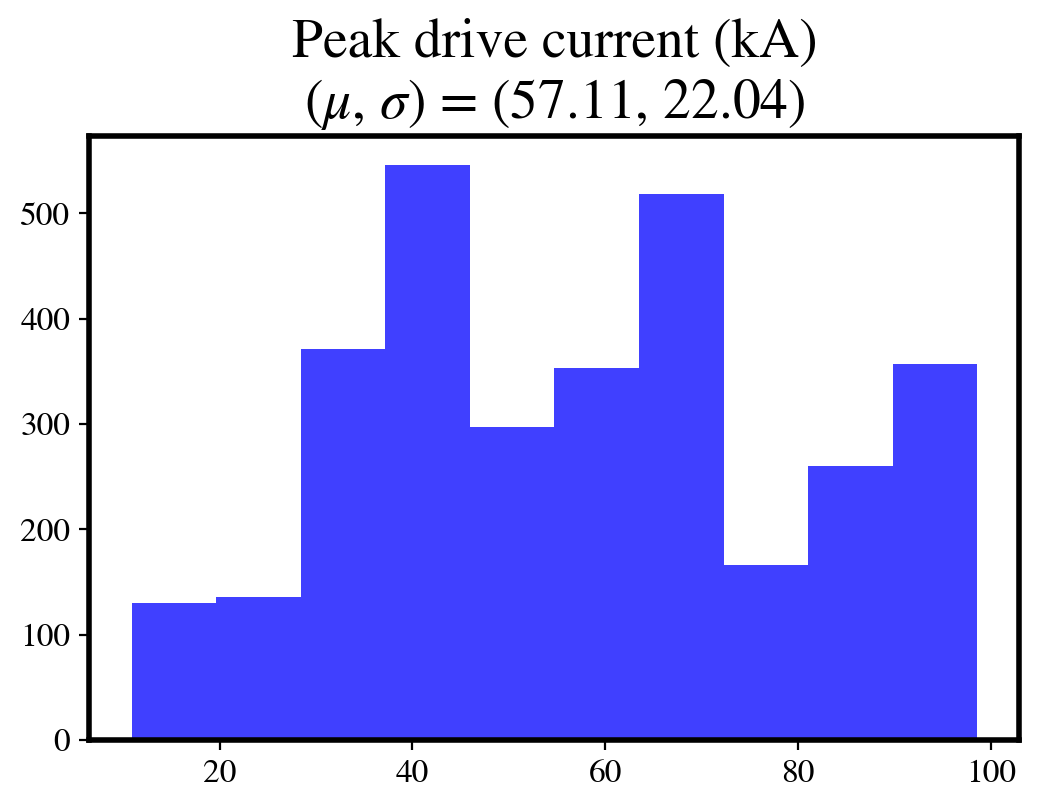

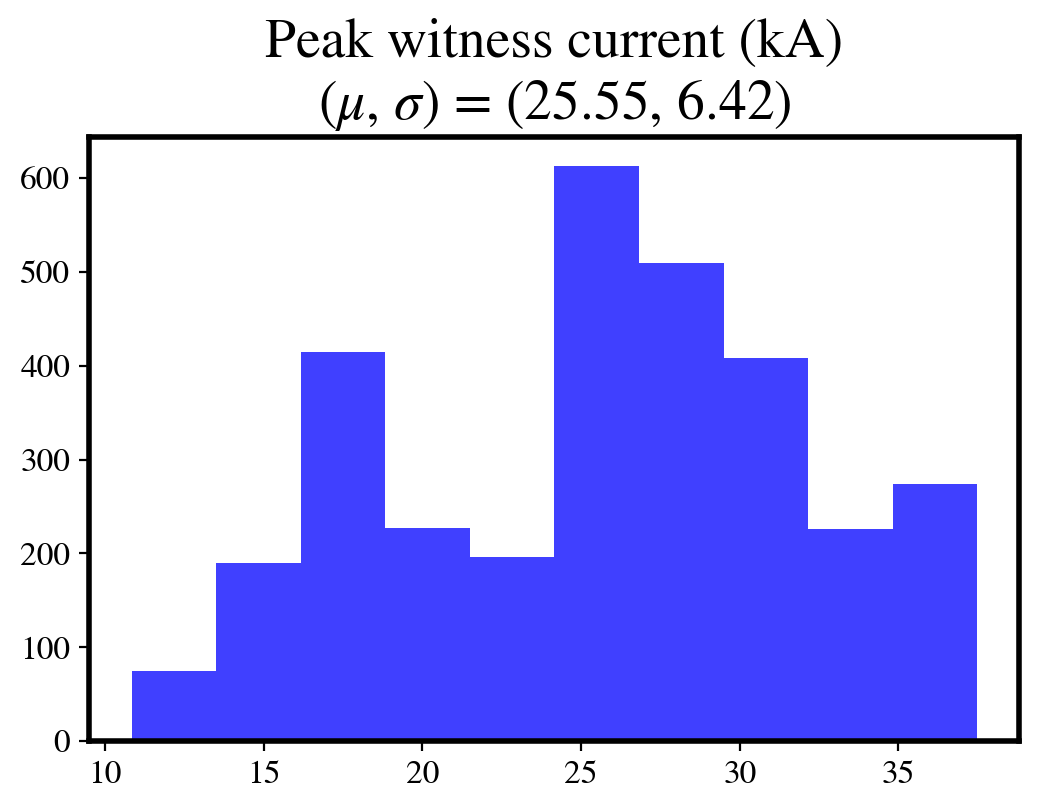

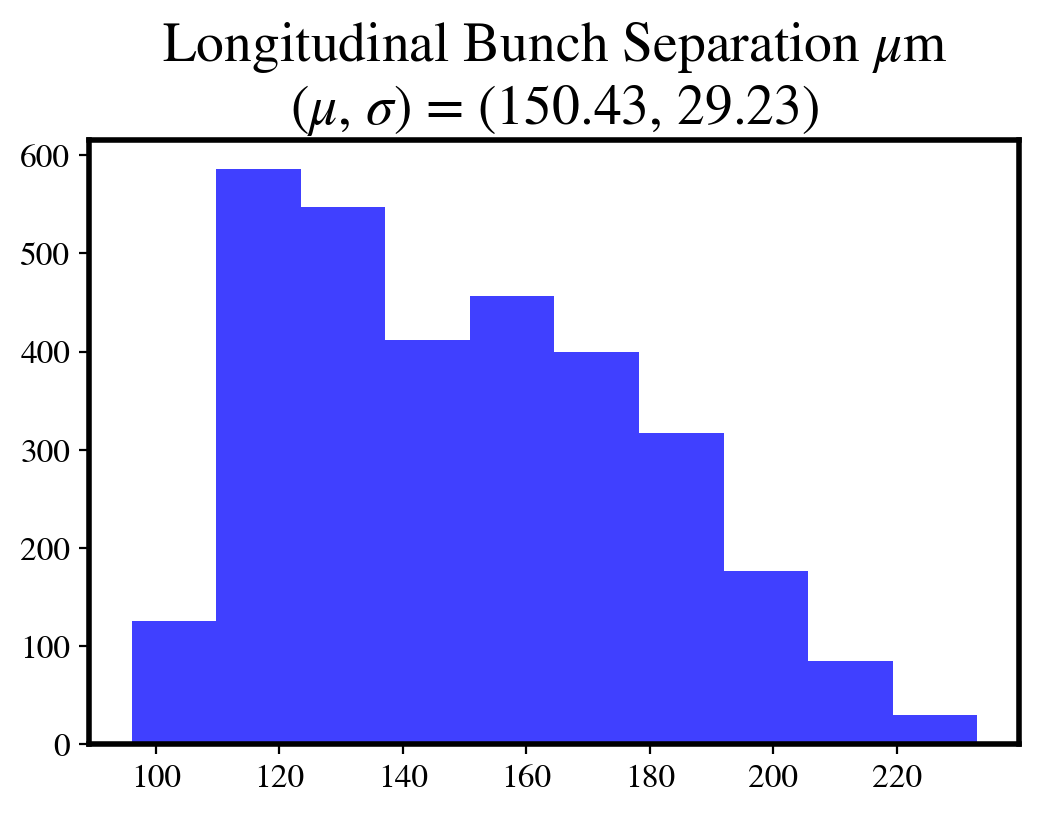

In [9]:
plot_param(npeaks, "Number of peaks")
plot_param(dI, "Peak drive current (kA)")
plot_param(dw, "Peak witness current (kA)")
plot_param(p2ps, r'Longitudinal Bunch Separation $\mu$m')